In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import k3d
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from utilis.resize_label import *
from utilis.callbacks import *
from utilis.utilis import *
from models.unet import *
from models.encoders.vgg_encoder import *

# Get data and labels

In [19]:
coord_data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512/"

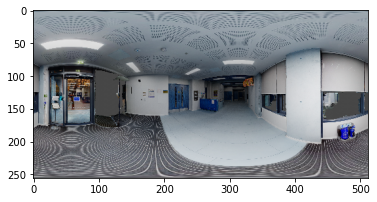

In [24]:
data_size = 1
images = np.zeros((data_size, 256, 512, 3), dtype=np.int16)
labels = np.zeros((data_size, 256, 512, 3), dtype=np.float32)


for ind in range(1,data_size + 1):

    coord_npz = f"{ind:03}_rendered.png_config.npz"
    npz_data = np.load(coord_data_dir + coord_npz)
    plt.figure()
    plt.imshow(npz_data['image_colors'])
#     images[int(ind)-1,:,:,:] = npz_data['image_colors']
#     labels[int(ind)-1,:,:,:] = npz_data['points_3d_camera']

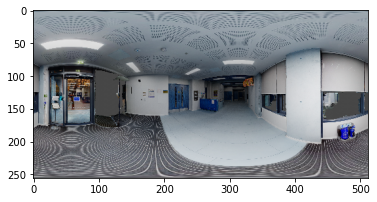

In [18]:
plt.imshow(images[0])

# Let's downsample image and label to 224x224 size

In [4]:
images_low = np.zeros((data_size, 224, 224, 3), dtype=np.int16)
labels_low = np.zeros((data_size, 224, 224, 3), dtype=np.float32)

for ind in range(data_size):
    images_low[ind,:,:,:] = cv2.resize(images[ind,:,:,:],(224, 224), interpolation = cv2.INTER_CUBIC)
    
for ind in range(data_size):
    labels_low[ind,:,:,:] = resize_coordinates(labels[ind,:,:,:], new_dim=(224,224))

# Artificially increse size of the dataset for testing

In [7]:
# images_new = np.concatenate((images_low, images_low), axis=0)
# labels_new = np.concatenate((labels_low, labels_low), axis=0)

In [8]:
# images_new = np.concatenate((images_new, images_new), axis=0)
# labels_new = np.concatenate((labels_new, labels_new), axis=0)

In [9]:
# images_new.shape

# Write a simple model

### single gpu

In [139]:
compile_configs = {'metrics': [keras.metrics.MeanAbsoluteError()]}

unet_model = vgg_unet()
unet_model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.0001), **compile_configs)

Epoch 1/2
1/1 [==============================] - ETA: 0s - loss: 4.0276 - mean_absolute_error: 1.4450WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f42bc099dd0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


/home/mlmi-2020/jz522/localisation_from_image_project/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator


1/1 [==============================] - 2s 2s/step - loss: 4.0276 - mean_absolute_error: 1.4450
Epoch 2/2
1/1 [==============================] - 0s 296ms/step - loss: 2.9853 - mean_absolute_error: 1.2634


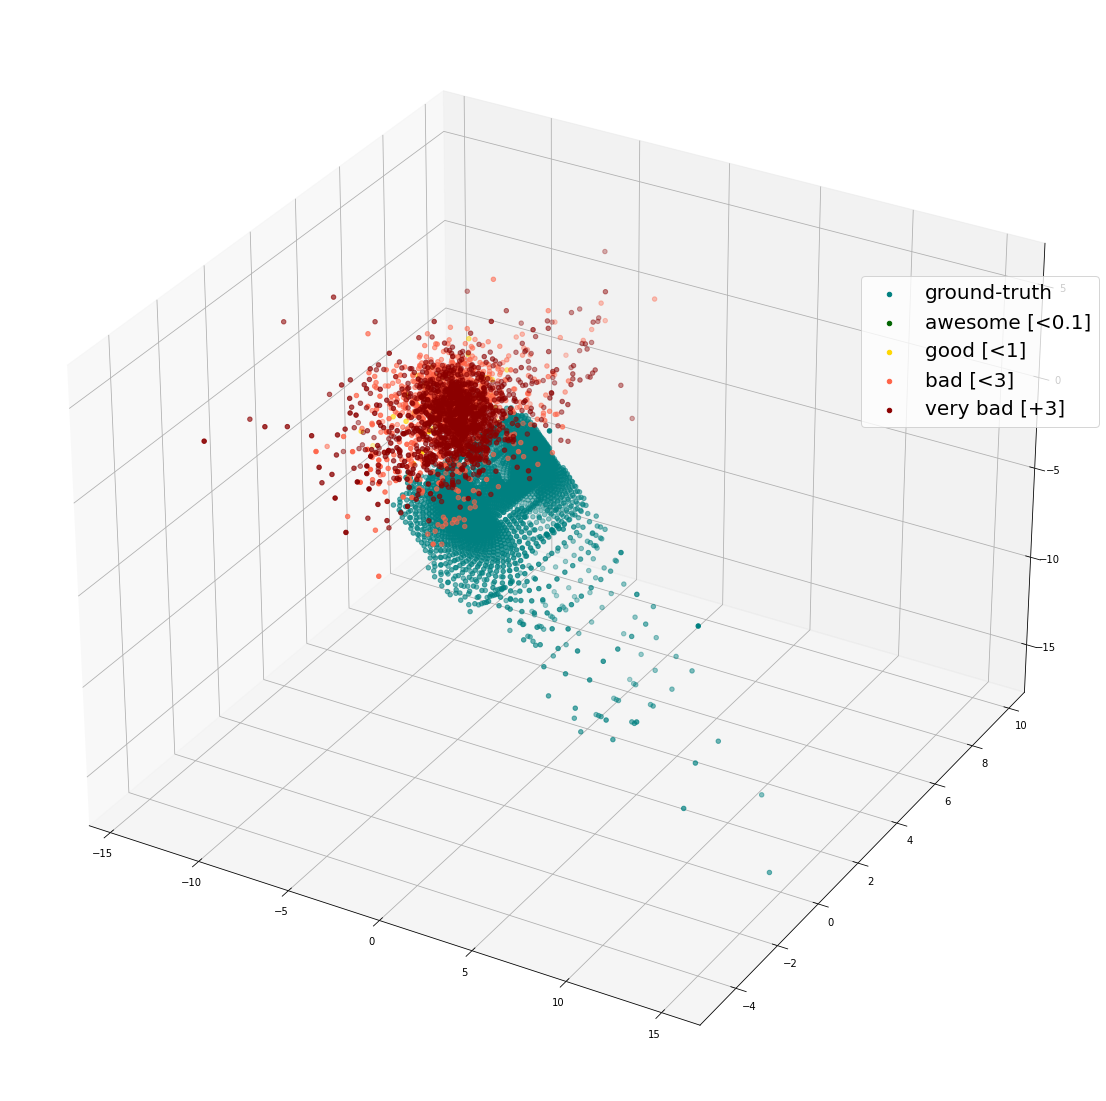

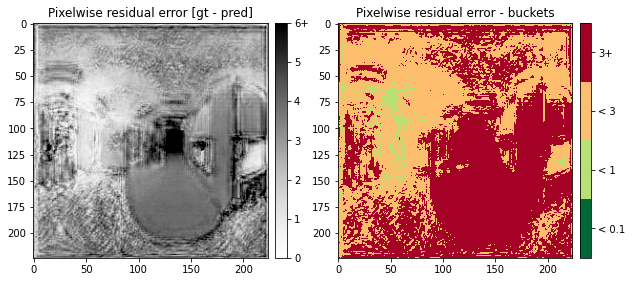

In [140]:
fit_configs = {'callbacks': [RemoveGarbageCallback(),
                             Visualise_learning(images_low[0], labels_low[0], 20, "testing_callbacks")
                                              ],
#                'batch_size': 128,
               'epochs': 2,
               'verbose': 1}

unet_model.fit(x=images_low, y=labels_low, **fit_configs)

### multiple gpu

In [23]:
get_available_gpus()

['/device:GPU:0',
 '/device:GPU:1',
 '/device:GPU:2',
 '/device:GPU:3',
 '/device:GPU:4',
 '/device:GPU:5',
 '/device:GPU:6',
 '/device:GPU:7']

In [29]:
# def vgg_unet(input_height=224, input_width=224):

#     model = unet(vgg_encoder, input_height=input_height, input_width=input_width)
#     model.model_name = "vgg_unet"
    
#     return model

In [31]:
strategy = tf.distribute.MirroredStrategy(['/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    
    compile_configs = {'metrics': [keras.metrics.MeanAbsoluteError()]}
                   
    fit_configs = {'callbacks': [RemoveGarbaseCallback(),
    #                            Visualise_learning(images_low[0], labels_low[0]
                                                  ],
                   'batch_size': 128,
                   'epochs': 5,
                   'verbose': 1}
    
    unet_model = vgg_unet()
    unet_model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.0001), **compile_configs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')
Number of devices: 4


In [32]:
unet_model.fit(x=images_new, y=labels_new, **fit_configs)

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1
4/4 [==============================] - 2s 432ms/step - loss: 3.1559 - mean_absolute_error: 1.2825
Epoch 2/5
4/4 [==============================] - 2s 422ms/step - loss: 1.3058 - mean_absolute_error: 0.8429
Epoch 3/5
4/4 [==============================] - 2s 451ms/step - loss: 0.7855 - mean_absolute_error: 0.6390
Epoch 4/5
4/4 [==============================] - 2s 468ms/step - loss: 0.5099 - mean_absolute_error: 0.5173
Epoch 5/5
4/4 [==============================] - 2s 447ms/step - loss: 0.3681 - mean_absolute_error: 0.4432


In [33]:
del unet_model

In [62]:
pred_y = unet_model.predict(images_low)

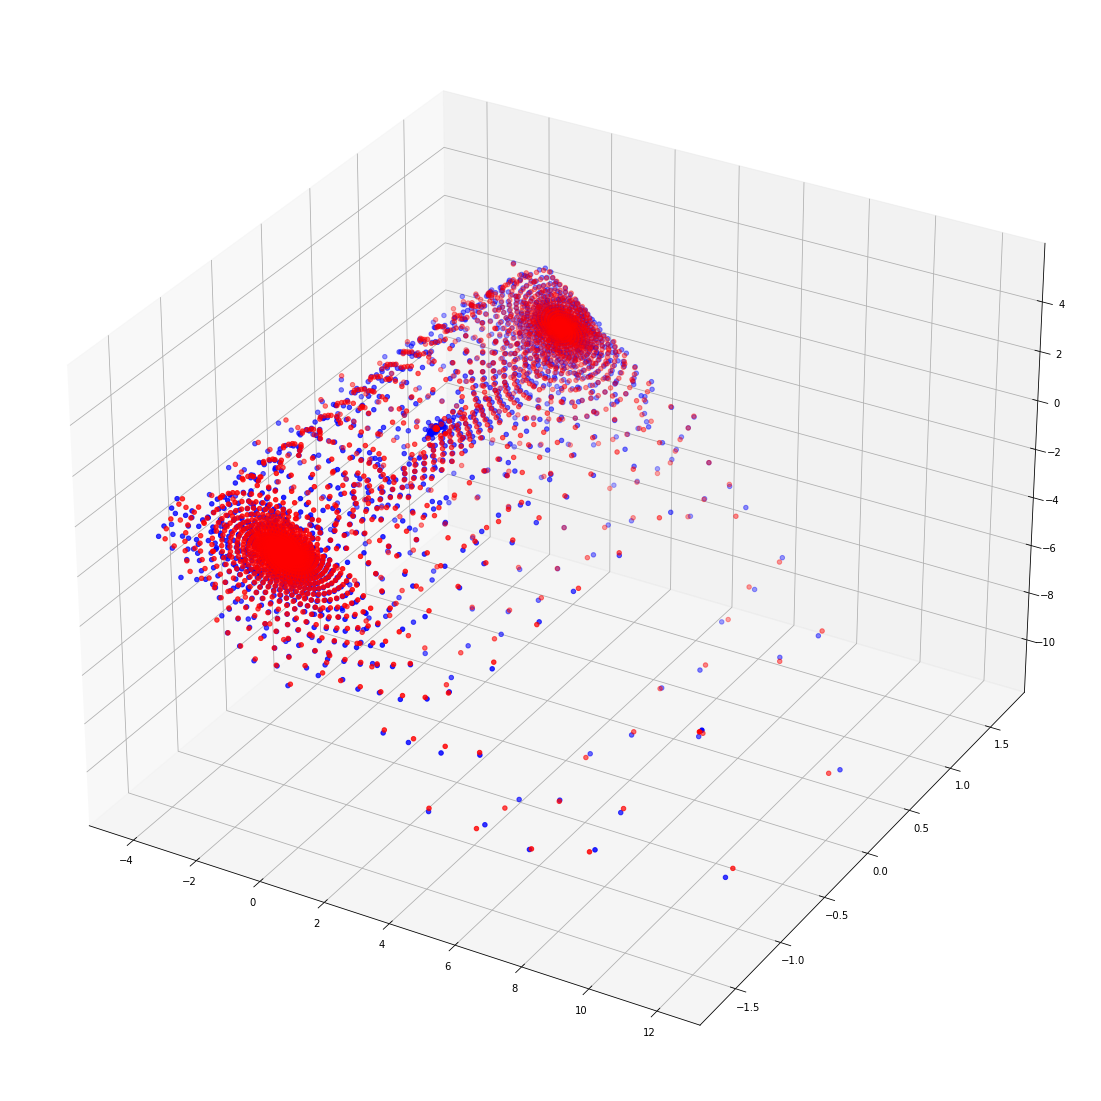

In [103]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

xyz = labels_low[0,:,:,:].reshape(-1, labels_low[0,:,:,:].shape[-1])[::20]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='r', marker='o')

xyz = pred_y[0,:,:,:].reshape(-1, pred_y[0,:,:,:].shape[-1])[::20]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='b', marker='o')

In [92]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=labels_low[2], point_size=0.2, color=0xff0000, alpha=0.5)
plot += plt_points
plt_points = k3d.points(positions=pred_y[2], point_size=0.2, color=0x0000ff, alpha=0.5)
plot += plt_points
plt_points.shader='3d'
plot.display()

Output()

In [93]:
plot.fetch_screenshot()

In [94]:
with open('screenshot.png', 'wb') as f:
#     try:
#         out = plot.screenshot.decode('base64')
#     except: # Python 3
    from base64 import b64decode
    out = b64decode(plot.screenshot)    
    f.write(out)
    
Image(url='screenshot.png')

In [82]:
plot.screenshot

''

In [75]:
image_dir = plot.screenshot
img = mpimg.imread(image_dir)
plt.imshow(img)

AttributeError: 'str' object has no attribute 'read'

TypeError: Image data of dtype <U1 cannot be converted to float

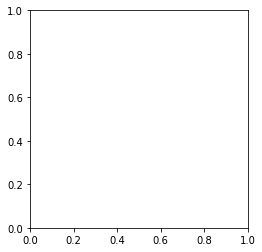

In [69]:
plt.imshow(plot.screenshot)